# **ANN for Classification**

**Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from scipy import stats
from statsmodels import robust
from sklearn.ensemble import IsolationForest

from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

**Loading Dataset**

In [2]:
df = pd.read_csv("../Datasets/Bank Customer Churn Prediction.csv")
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Checking for duplicates**

In [3]:
df.duplicated().sum()

np.int64(0)

**Checking for missing values**

In [4]:
df.isna().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

**Dropping Unnecessary columns**

In [5]:
df = df.drop("customer_id", axis=1)
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df['churn'].value_counts()

churn
0    7963
1    2037
Name: count, dtype: int64

This dataset is heavily imbalanced and biased towards 0 (not churning) and we will have to balance the dataset

**Handling Categorical Variables**

We will convert the gender into Binary using Label Encoder

In [7]:
#converting the value of column to 0 or 1
from sklearn.preprocessing import LabelEncoder

variables = ['gender']

encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

We will convert the country into Nominal variable using OneHotEncoder

In [8]:
from sklearn.preprocessing import OneHotEncoder

variables = ['country']

encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [9]:
df = df.drop("country_France", axis=1)
df.head()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1


**Balancing Dataset**

**Removing Outliers**

In [10]:
#code from chatgpt to remove these outliers
numeric_cols = ['age', 'country_Germany', 'country_Spain', 'balance', 'estimated_salary', 'credit_card', 'tenure', 'credit_score',
                'products_number', 'gender', 'active_member']

target_col = 'churn'

# Z-SCORE OUTLIER REMOVAL
for col in numeric_cols:
    z = np.abs(stats.zscore(df[col]))
    df[f'{col}_z_outlier'] = (z > 3).astype(int)
    
z_outlier_mask = df[[f'{c}_z_outlier' for c in numeric_cols]].sum(axis=1) == 0
df_z_removed = df[z_outlier_mask].copy()

print(f"Removed {len(df) - len(df_z_removed)} rows based on Z-score (>|3|).")

# ISOLATION FOREST OUTLIER REMOVAL

iso = IsolationForest(contamination=0.02, random_state=42)
iso_preds = iso.fit_predict(df_z_removed[numeric_cols])
df_z_removed['iso_outlier'] = iso_preds

df_clean = df_z_removed[df_z_removed['iso_outlier'] == 1].copy()
removed_iforest = (df_z_removed['iso_outlier'] == -1).sum()

print(f"Removed {removed_iforest} rows based on Isolation Forest (multivariate).")

print("\n=== SUMMARY ===")
print(f"Original dataset size: {len(df)}")
print(f"After Z-score removal: {len(df_z_removed)}")
print(f"After Isolation Forest removal: {len(df_clean)}")
print(f"\nTotal rows removed: {len(df) - len(df_clean)}")
print(df_clean['churn'].value_counts())


Removed 201 rows based on Z-score (>|3|).
Removed 196 rows based on Isolation Forest (multivariate).

=== SUMMARY ===
Original dataset size: 10000
After Z-score removal: 9799
After Isolation Forest removal: 9603

Total rows removed: 397
churn
0    7776
1    1827
Name: count, dtype: int64


**Balancing with CTGAN**

In [ ]:
df = df_clean.copy()
target = 'churn'

print("Class distribution before balancing:")
print(df[target].value_counts(), "\n")

minority_class = df[df[target] == 1]
majority_class = df[df[target] == 0]

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

ctgan = CTGANSynthesizer(metadata)
ctgan.fit(minority_class)

synthetic_minority = ctgan.sample(num_rows=3000)

synthetic_minority[target] = 1

df_balanced = pd.concat([df, synthetic_minority], ignore_index=True)

print("\nClass distribution after balancing:")
print(df_balanced[target].value_counts())



Class distribution before balancing:
churn
0    7776
1    1827
Name: count, dtype: int64 



c:\Users\stsaa\Desktop\Deep-Learning\.venv\Lib\site-packages\sdv\single_table\base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\stsaa\Desktop\Deep-Learning\.venv\Lib\site-packages\sdv\single_table\base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(



Class distribution after balancing:
churn
0    7776
1    4827
Name: count, dtype: int64


The Dataset is not exactly balanced still but creating too many synthetic values was resulting in lower metrics and false positives. Right now its working better than before atleast.

**Defining X and y variables**

In [13]:
X = df_balanced.drop("churn", axis=1)

y_temp = df_balanced['churn']

**Encoding**

In [14]:
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

y = tf.keras.utils.to_categorical(y_enc)
categories = list(le.classes_)
categories = list(map(str, categories))
categories

['0', '1']

**Train/test/Validation split**

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.35)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

**KERAS TUNER**

In [16]:
import keras_tuner

def build_model(hp):
    # iniatlize sequential test neural network
    model = keras.Sequential()

    # first layer, batch normalization + input shape, same as in typical neural network
    model.add(layers.BatchNormalization(input_shape=(len(X.columns),)),)
    
    # add the first actual layer including the regularizer
    model.add(
        layers.Dense(
            # Tune number of units separately.
            units=hp.Int(f"units_0", min_value=4, max_value=96, step=4),
            activation=hp.Choice("activation", ["relu"]),
            kernel_regularizer=keras.regularizers.l1(hp.Float("l1", min_value=0.025, max_value=0.35, sampling="log"))
        )
    )
        
    # automate a dropout layer
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(
            hp.Float("rate", min_value=0.1, max_value=0.5, step=0.025)
            ))

    # try additional layers, 1-3 extra layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i + 1}", min_value=8, max_value=96, step=4),
                activation=hp.Choice("activation", ["relu"]),
            )
        )

    # output layer, only one node since this is regression
    model.add(layers.Dense(len(categories), activation="softmax"))

    # automate learning rate tests
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")

    # compile the test neural network
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy', metrics=['accuracy']
    )

    return model


# build the model + use RandomSearch to actually search the best options for our neural network
build_model(keras_tuner.HyperParameters())

# use val_loss as the objective, because regression tasks do not have accuracy
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="optimizations1",
    project_name="classification1test",
)

# start searching
tuner.search(X_train, y_train, epochs=250, validation_data=(X_val, y_val))

Trial 5 Complete [00h 02m 13s]
val_accuracy: 0.8098368048667908

Best val_accuracy So Far: 0.8533544838428497
Total elapsed time: 00h 11m 14s


In [18]:
tuner.results_summary()

Results summary
Results in optimizations1\classification1test
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
units_0: 12
activation: relu
l1: 0.04908561161149619
dropout: False
num_layers: 2
units_1: 92
lr: 0.0010477328827800908
units_2: 56
units_3: 32
Score: 0.8533544838428497

Trial 2 summary
Hyperparameters:
units_0: 16
activation: relu
l1: 0.02887530684198039
dropout: False
num_layers: 3
units_1: 16
lr: 0.0026532711207386452
units_2: 48
units_3: 44
Score: 0.8485947251319885

Trial 1 summary
Hyperparameters:
units_0: 24
activation: relu
l1: 0.1047393702365571
dropout: False
num_layers: 3
units_1: 96
lr: 0.0022943280068135692
units_2: 52
units_3: 48
Score: 0.8399818539619446

Trial 4 summary
Hyperparameters:
units_0: 12
activation: relu
l1: 0.23660819692630242
dropout: True
num_layers: 1
units_1: 28
lr: 0.0002800733257734468
units_2: 60
units_3: 76
rate: 0.1
Score: 0.8098368048667908

Trial 0 summary
Hyperparameters:
units_0: 

In [19]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 23)             │            92 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 92)             │         1,196 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 56)             │         5,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           114 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,898 (26.95 KB)

 Trainable params: 6,852 (26.77 KB)

 Non-trainable params: 46 (184.00 B)

**Neural Network**

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

mc = ModelCheckpoint('best_model_classification1_kt.keras', monitor='val_accuracy', mode='max', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=100, mode="min")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.0005)

callback_list = [mc,es,reduce_lr]

model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(12, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.04908561161149619)),
        layers.Dense(92, activation="relu"),
        layers.Dense(56, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

optimal_lr = 0.0010477328827800908

model.compile(optimizer=keras.optimizers.Adam(learning_rate=optimal_lr), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 23)             │            92 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 92)             │         1,196 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 56)             │         5,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           114 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,898 (26.95 KB)

 Trainable params: 6,852 (26.77 KB)

 Non-trainable params: 46 (184.00 B)

**Training**

In [21]:
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/500
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7332 - loss: 2.0654 - val_accuracy: 0.7693 - val_loss: 1.0086 - learning_rate: 0.0010
Epoch 2/500
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.7812 - loss: 0.6656 - val_accuracy: 0.8119 - val_loss: 0.5129 - learning_rate: 0.0010
Epoch 3/500
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.7937 - loss: 0.5129 - val_accuracy: 0.8214 - val_loss: 0.4625 - learning_rate: 0.0010
Epoch 4/500
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.8030 - loss: 0.4896 - val_accuracy: 0.8164 - val_loss: 0.4555 - learning_rate: 0.0010
Epoch 5/500
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.8037 - loss: 0.4769 - val_accuracy: 0.8173 - val_loss: 0.4454 - learning_rate: 0.0010
Epoch 6/500
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.8111 - loss: 0.4710 - val_accuracy: 0.8178 - val_loss: 0.4524 - learning_rate: 0.0010
Epoch 7/500
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.810

<Axes: >

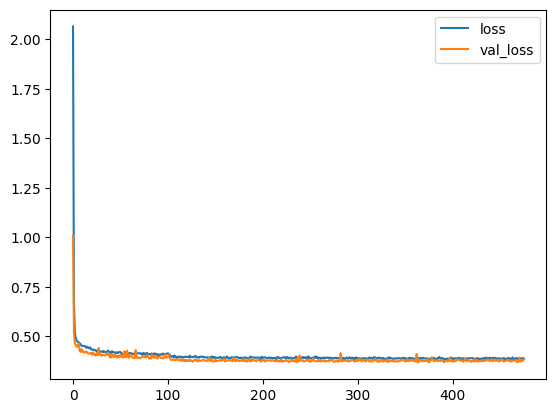

In [22]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

the model seems to be learning well without extreme spikes

<Axes: >

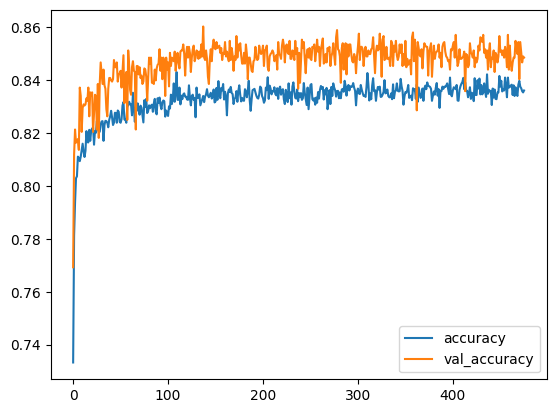

In [23]:
loss_df[['accuracy', 'val_accuracy']].plot()

the validation accuracy is higher showing that there could be further optimisations and it is hitting plateu at around 0.84 so we could also increase senstivity of ReduceLRonPlatue and Early stop.

**Loading Best Model**

In [24]:
from keras.models import load_model
model = load_model('best_model_classification1_kt.keras')

**Evaluations**

In [25]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.3798127770423889, 0.8368086814880371]

Train data evaluation:
[0.370432585477829, 0.8461726307868958]


In [26]:
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

y_test = np.argmax(y_test, axis=1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step


**Confusion Matrix**

<Axes: >

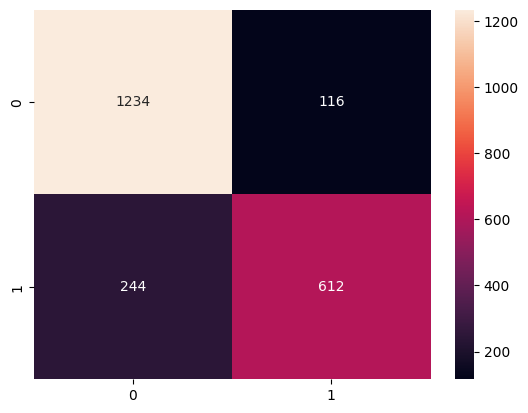

In [27]:
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories)

Now the outputs are slightly more balanced than before

**Metrics**

In [28]:
print(classification_report(y_test, test_predictions, target_names=['No Churn', 'Churn']))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

    No Churn       0.83      0.91      0.87      1350
       Churn       0.84      0.71      0.77       856

    accuracy                           0.84      2206
   macro avg       0.84      0.81      0.82      2206
weighted avg       0.84      0.84      0.83      2206


Model overall accuracy: 83.68%


The metrics are also better compared to unoptimised ANN and Logistic Regression and it is catching the minority class a bit better too 

In [29]:
roc_auc_score(y, model.predict(X), multi_class="ovr")

394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


0.9133583791895041

ROC score also confirms that the model is working much better than others

**Testing with Imaginary Values**

In [30]:
df.tail()

,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,...,country_Spain_z_outlier,balance_z_outlier,estimated_salary_z_outlier,credit_card_z_outlier,tenure_z_outlier,credit_score_z_outlier,products_number_z_outlier,gender_z_outlier,active_member_z_outlier,iso_outlier
9995,771,1,39,5,0.00,2,1,0,96270.64,0,...,0,0,0,0,0,0,0,0,0,1
9996,516,1,35,10,57369.61,1,1,1,101699.77,0,...,0,0,0,0,0,0,0,0,0,1
9997,709,0,36,7,0.00,1,0,1,42085.58,1,...,0,0,0,0,0,0,0,0,0,1
9998,772,1,42,3,75075.31,2,1,0,92888.52,1,...,0,0,0,0,0,0,0,0,0,1
9999,792,0,28,4,130142.79,1,1,0,38190.78,0,...,0,0,0,0,0,0,0,0,0,1


In [31]:
expected_cols = X_train.columns
# Gender -column: 0 => Female, 1 => Male
tester_row = {
    'credit_score': 771,
    'gender': 1,
    'age': 39,
    'tenure': 5,
    'balance': 0.0,
    'products_number': 2,
    'credit_card': 1,
    'active_member': 0,
    'estimated_salary': 96270.64,
    'country_Germany':0,
    'country_Spain':0

}
# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
for col in expected_cols:
    if col not in tester_row.columns:
        tester_row[col] = 0
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

# switch to decimal representation 
np.set_printoptions(precision=9, suppress=True)

# 0 cheapest, 3 most expensive
print(f"Predicted price range: {result_text}")
print()
print("Probabilities by class:")
print(categories)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted price range: 0

Probabilities by class:
['0', '1']
[0.9528941   0.047105853]


**Summary**

The unoptimised version showed a similar trend as regression where its better to use classic ML as they are lighter and works better for simpler datasets but ANN allows more control and optimisation which makes it useful to cover relations and intricasies which classic ML algorthms fail to capture. Optimised ANN for classification also produced better results than Logistic Regression.